In [16]:
import requests
from stocks import *
import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
nltk.download('punkt')
import string  
import csv
import re
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
nltk.download('vader_lexicon')
from pprint import pprint
from matplotlib.pyplot import figure

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/rohansuresh/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/rohansuresh/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [17]:
# description:
#   function to get company name from ticker symbol using the yahoo finance api. 
#   https://stackoverflow.com/questions/38967533/retrieve-company-name-with-ticker-symbol-input-yahoo-or-google-api
# args:
#   symbol - ticker symbol for company
# return:
#   company_name - company name associated with ticker
def get_company_name(symbol):
    url = "http://d.yimg.com/autoc.finance.yahoo.com/autoc?query={}&region=1&lang=en".format(symbol)

    result = requests.get(url).json()

    for x in result['ResultSet']['Result']:
        if x['symbol'] == symbol:
            company_name = x['name']
            return company_name

In [18]:
# description:
#   function to remove stop words and other general words in company name to have more concise reference
#   to company
#   e.g. "The Coca-Cola Company" could also be simply referred to as "Coca-Cola"
# args:
#   company_name - Name of company we want to get permutations of
# return:
#   company_name_perm - Different permutations of company name
def get_cleaned_name(symbol):

    stop_words = set(stopwords.words('english')) 
    word_tokens = word_tokenize(symbol) 
    filtered_sentence = [w for w in word_tokens if not w.lower() in stop_words] 
    
    # words similar to organisation, inc, etc. gathered by going through DOW 30
    remove_words = ["company", "co", "co.", "inc", "inc.", "corporation", "group", "incorporated", "alliance"]
    filtered_sentence = [w for w in filtered_sentence if not w.lower() in remove_words] 
    
    # if the company name was "<some_name> & <word_in_remove_words>" we should remove the '&' symbol
#     if filtered_sentence[-1] == "&":
#         filtered_sentence = filtered_sentence[:-1]
        
    # create string from tokenized string
    output = ' '.join(filtered_sentence)
    output2 = ""
    
    # clean up punctuation formatting errors
    punc = ["'", '"', ',', '.', "&"]
    for i in range(len(output)):
        if output[i] not in punc:
            output2 += output[i]
        else:
            if output[i] == "'" or output[i] == '"':
                try:
                    output2 = output2[:-1]
                    output2 += output[i]
                except:
                    output2 = ""
            elif output[i] == '.' or output[i] == ',':
                try:
                    output2 = output2[:-1]
                except:
                    output2 = ""
            elif output[i] == '&' and i==len(output)-1:
                try:
                    output2 = output2[:-1]
                except:
                    output2 = output2
                    
    # clean up multiple white spaces
    output2= ' '.join(output2.split())

    return output2
    
tickers = get_dow_tickers()
for ticker in tickers:
    print("Ticker: " + ticker, end=" - ")
    company = get_company_name(ticker)
    print(company)
    print(get_cleaned_name(company))
    print(" ")

Ticker: JPM - JPMorgan Chase & Co.
JPMorgan Chase
 
Ticker: IBM - International Business Machines Corporation
International Business Machines
 
Ticker: UNH - UnitedHealth Group Incorporated
UnitedHealth
 
Ticker: PG - The Procter & Gamble Company
Procter Gamble
 
Ticker: BA - The Boeing Company
Boeing
 
Ticker: VZ - Verizon Communications Inc.
Verizon Communications
 
Ticker: GS - The Goldman Sachs Group, Inc.
Goldman Sachs
 
Ticker: INTC - Intel Corporation
Intel
 
Ticker: HD - The Home Depot, Inc.
Home Depot
 
Ticker: MCD - McDonald's Corporation
McDonald's
 
Ticker: CSCO - Cisco Systems, Inc.
Cisco Systems
 
Ticker: V - Visa Inc.
Visa
 
Ticker: MSFT - Microsoft Corporation
Microsoft
 
Ticker: KO - The Coca-Cola Company
Coca-Cola
 
Ticker: AXP - American Express Company
American Express
 
Ticker: AMGN - Amgen Inc.
Amgen
 
Ticker: MRK - Merck & Co., Inc.
Merck
 
Ticker: CVX - Chevron Corporation
Chevron
 
Ticker: MMM - 3M Company
3M
 
Ticker: TRV - The Travelers Companies, Inc.
Travel

In [19]:
# description:
#   given the folder name, read the CSV and put the headlines into a dictionary where key is the date in the 
#   form 'YYYY-MM' and value is all headlines from that time period
#   using this Kaggle dataset: https://www.kaggle.com/notlucasp/financial-news-headlines
# args:
#   folder_name - folder with csvs
# return:
#   guardian_dict - dictionary of guardian headlines
def read_csvs(folder_name):

    # create dictionary of guardian articles where key is date and value is the article
    guardian_dict = {}
    
    # boolean to skip the header
    not_header = False
    
    # create dictionary of months to easily get month number
    months_arr = ["ignore", "Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
    months_dict = {}
    for i in range(len(months_arr)):
        months_dict[months_arr[i]] = i
        
    # open file
    with open(folder_name+'guardian_headlines.csv', newline='') as f:
        reader = csv.reader(f)
        # iterate over file
        for row in reader:
            if not_header:
                # split date into array using '-' as delimter
                date_arr = row[0].split('-')
                # dates formatted in two different ways
                # if formatted like so "day(num)-month(three letters)-year(last 2 digits)"
                # use the below code chunk to format date
                try:
                    month = date_arr[1]
                    month_num = months_dict[month]
                    date = "20" + str(date_arr[2]) + "-" + str(month_num)
                # else if date formatted like so "month(three letters)-year(last 2 digits)"
                # use below code chunk to format date
                except:
                    month = date_arr[0]
                    month_num = months_dict[month]
                    date = "20" + str(date_arr[1]) + "-" + str(month_num)
                    
                # put all articles onto one line
                article = row[1].replace("\n", " ")
                # remove excess whitespace
                article = re.sub(' +', ' ', article)
                
                try:
                    article_arr = guardian_dict[date]
                    article_arr.append(article)
                    guardian_dict[date] = article_arr
                except:
                    guardian_dict[date] = [article]
                
            else:
                not_header = True
               
    ################################################################################################
    
    #TODO: FIND HOW TO STANDARDIZE DATES - DATES IN CNBC CSV NOT STANDARDIZED
    
#     # create dictionary of cnbc articles where key is date and value is the article
#     cnbc_dict = {}
    
#     # boolean to skip the header
#     not_header = False
    
#     # open file
#     with open(folder_name+'cnbc_headlines.csv', newline='') as f:
#         reader = csv.reader(f)
#         # iterate over file
#         for row in reader:
#             if not_header:
#                 date = row[1].split(",")
#                 if date != ['']:
                    
#                     temp = date[1].split(" ")
# #                     print(temp)
#                     date = temp[3]+"-"+temp[2]
#                     cnbc_dict[date] = row[0]
#             else:
#                 not_header = True
                
    
#     return guardian_dict, cnbc_dict
    return guardian_dict

guardian_dict = read_csvs('786286_1351005_bundle_archive/')
get_time_intervals("2017-01", "2017-05", 1)

[('2017-1-1', '2017-2-1'),
 ('2017-2-1', '2017-3-1'),
 ('2017-3-1', '2017-4-1'),
 ('2017-4-1', '2017-5-1')]

In [20]:
# description:
#   given a headlines_dict, time interval, and ticker, find relevant articles, conduct
#   semantic analysis using nltk on the headlines and return the score for each time interval
# args:
#   headlines_dict - dictionary where key is the date in the form 'YYYY-MM' and value is all headlines from that time period 
#   start - start date in the form "YYYY-MM"
#   end - end date in the form "YYYY-MM"
#   interval - size of each time interval we want to get data points for
#   ticker - ticker for respective company
# return:
#   sentiment_arr - score for each time interval given available headlines corressponding to the company.
def semantic_analysis_guardian(headlines_dict, start, end, interval, ticker):
    
    # get time intervals formatted correctly
    time_intervals = get_time_intervals(start, end, interval)
    for i in range(len(time_intervals)): 
        time_intervals[i] = time_intervals[i][0][:-2]

    # get company name
    company_name = get_company_name(ticker)
    company_name = get_cleaned_name(company_name)
    
    # get articles relating to company
    relevant_headlines = {}
    for val in time_intervals:
        headlines = guardian_dict[val]
        relevant = []
        for headline in headlines:
            if company_name in headline.split(" "):
                relevant.append(headline)
        relevant_headlines[val] = relevant
        
    # find seniment of new headlines for each time interval
    sentiment_dict = {}
    sentiment_arr = []
    num_rel_headlines = []
    for val in time_intervals:
        headlines = relevant_headlines[val]
        sentiment = 0
        # Sentiment Intensity Analyzer
        sia = SIA()
        results = []
        for line in headlines:
            pol_score = sia.polarity_scores(line)
            pol_score['headline'] = line
            results.append(pol_score)
        for result in results:
            # using this heuristic to calculate score:
            # sentiment = compounds sentiment
            # -1 is extremely negative and 1 is extremely positive
            sentiment += (result['compound'])
        sentiment_dict[val] = sentiment
        sentiment_arr.append(sentiment)
        num_rel_headlines.append(len(results))
    return sentiment_arr, num_rel_headlines
            
    
guardian_dict = read_csvs('786286_1351005_bundle_archive/')
semantic_analysis_guardian(guardian_dict, "2018-01", "2018-12", 1, "AAPL")

([0.1779,
  0.0772,
  0.0,
  0.19790000000000002,
  0.3252,
  -0.5106,
  0.3182,
  1.0162,
  0.1628,
  0.0,
  -0.2732],
 [3, 2, 1, 3, 2, 1, 2, 5, 2, 1, 2])

In [21]:
# description:
#   plot a line graph with highs and low prices, semantic analysis scores, and # headlines over the interval
# args:
#   ticker - ticker for a specific company
#   highs - price highs for each corresponding interval
#   lows - price lows for each corresponding interval
#   intervals - array with each value being a tuple with its own start date and end date of interval length
# return:
# 
def plot_single_company_w_semantic(ticker, start, end, interval_length):
    
    guardian_dict = read_csvs('786286_1351005_bundle_archive/')
    semantic_results, num_rel_headlines = semantic_analysis_guardian(guardian_dict, start, end, interval_length, ticker)
    # plot graph for each ticker
    highs, lows, intervals = get_highs_and_lows_for_ticker(ticker, start, end, interval_length)
    
    # scale the semantic analysis scores up so trends are clearer
    avg = (sum(highs)+sum(lows))/(len(highs)*2)
    print(avg)
    print(semantic_results)
    heuristic = []
    heuristic.append(0)
    for i in range(len(semantic_results)):
        semantic_results[i] = (semantic_results[i]+1)*avg/2
        num_rel_headlines[i] *= 5
        heuristic.append((semantic_results[i]+num_rel_headlines[i])/2)
    heuristic = heuristic[:-1]
    
    time_arr = [ticker]
    
    intervals_formatted = []
    for i in range(len(intervals)):
        intervals_formatted.append("|" + str(intervals[i][0][:-2]) + " - " + str(intervals[i][1][:-2]) + "|")
    
    figure(num=None, figsize=(20, 6), dpi=80, facecolor='w', edgecolor='k')
    plt.plot(intervals_formatted, highs, label = "Highs")
    plt.plot(intervals_formatted, lows, label = "Lows")
#     plt.plot(intervals_formatted, semantic_results, label = "Semantic Analysis")
#     plt.plot(intervals_formatted, num_rel_headlines, label = "# Headlines")
    plt.plot(intervals_formatted, heuristic, label = "Heuristic")
    
    # get company name
    try:
        company_name = get_company_name(ticker)
        company_name = get_cleaned_name(company_name)
    except:
        company_name = ticker
        
    # if no data available for any interval then just print error 
    if len(intervals) == 0:
        plt.suptitle("No data available for " + company_name)
    else:
        plt.suptitle("Highs and Lows of " + company_name + " from " + intervals[0][0][:-2] + "-\n" + intervals[-1][1][:-2])
    plt.ylabel('Price')
    plt.xlabel('Interval')
    plt.legend()
    plt.show()

9.358699870924235
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


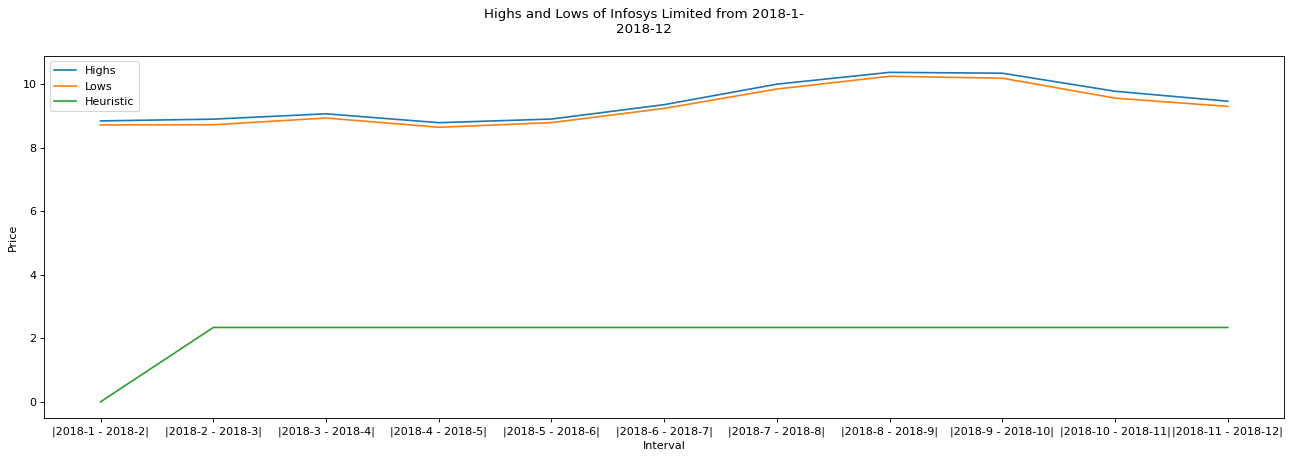

72.94706387268457
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


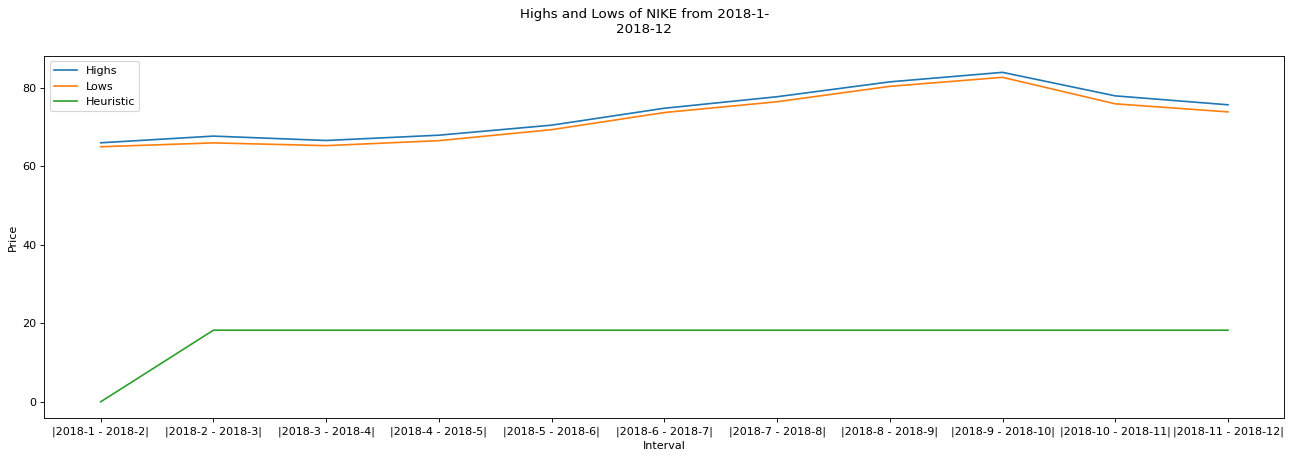

63.083237279821766
[0.5423, -0.3182, 0.0, 0.4404, -1.0067, 0.296, -0.04300000000000004, 1.3318999999999999, 0.4245, 0.2789, 0]


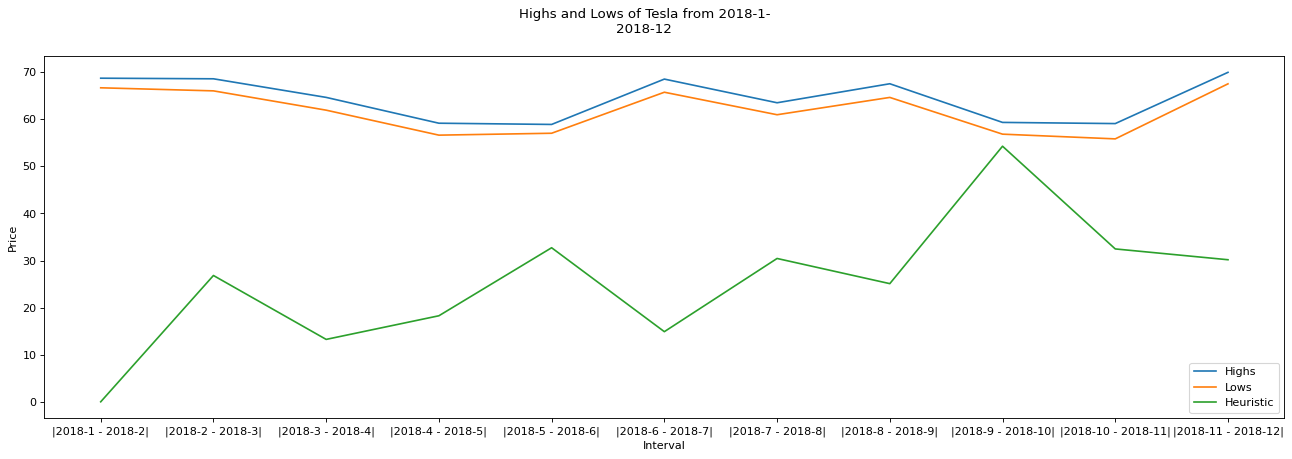

47.70375760390937
[0.1779, 0.0772, 0.0, 0.19790000000000002, 0.3252, -0.5106, 0.3182, 1.0162, 0.1628, 0.0, -0.2732]


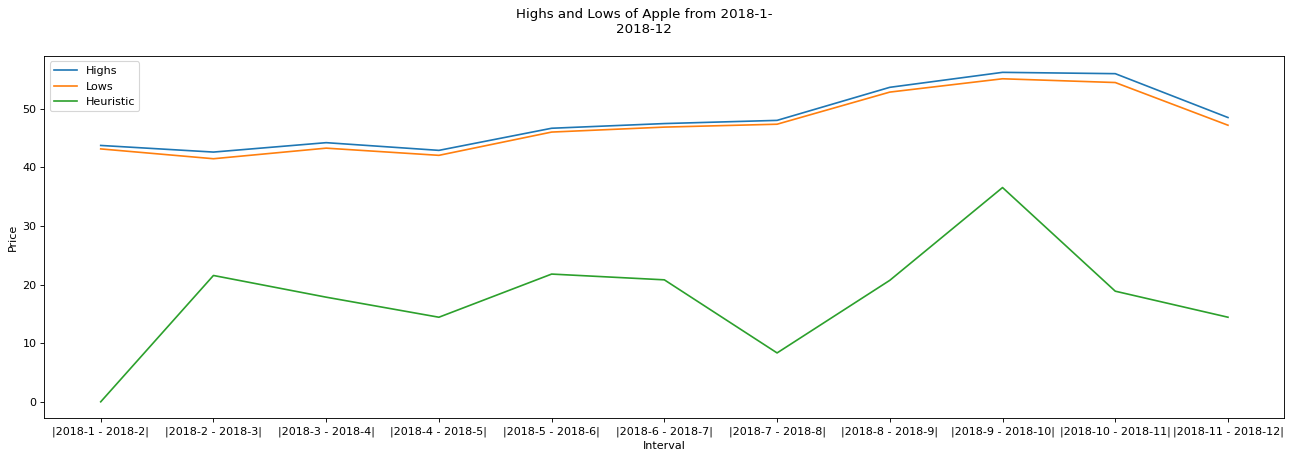

174.2660336049698
[0.3612, 0.04840000000000003, 0.47909999999999997, -0.9506, 0, 0.0, 0.15549999999999997, -0.30670000000000003, -0.1027, 0.6317999999999999, 0.431]


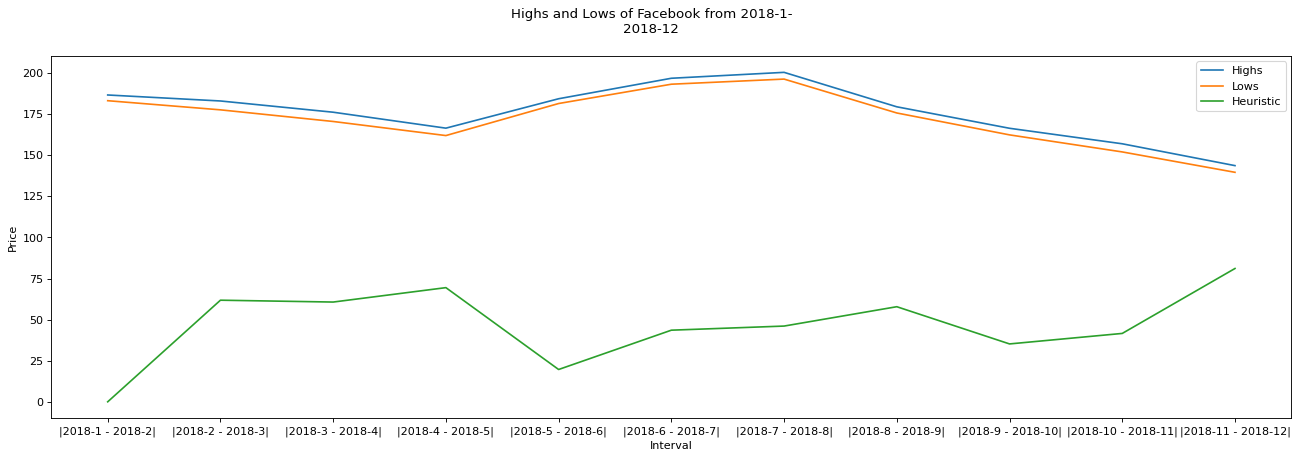

323.22784018876104
[-0.20389999999999997, -0.5733, -0.4215, 0.8509, 1.0362, -0.09369999999999998, 0.9249, 0, -0.166, 1.0946, 0.0]


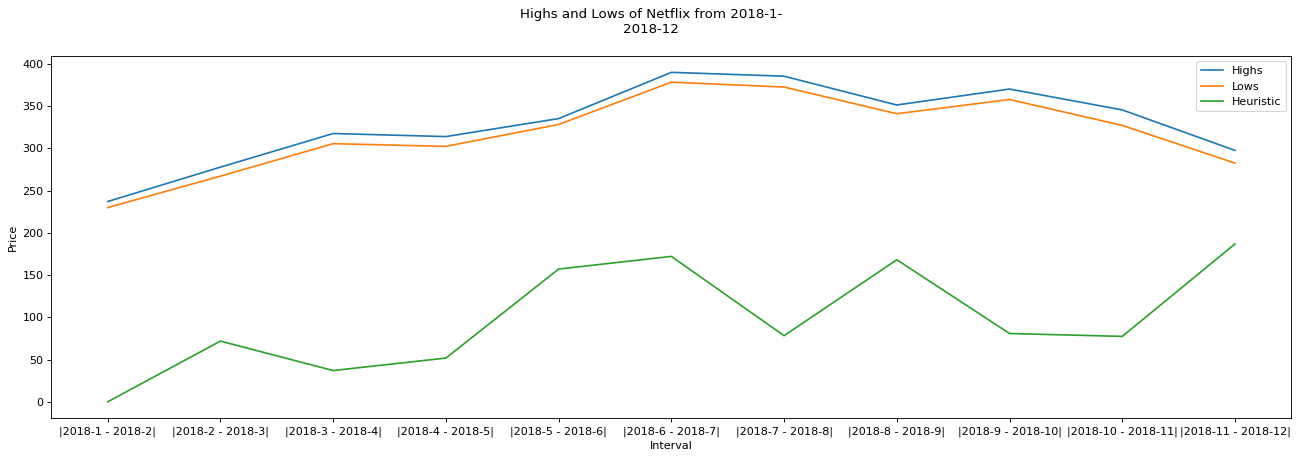

32.87695702653363
[-0.4019, 0.4404, 0, 0.4404, 0, 0, 0.0, 0.0, 0, 0.6249, 0.0]


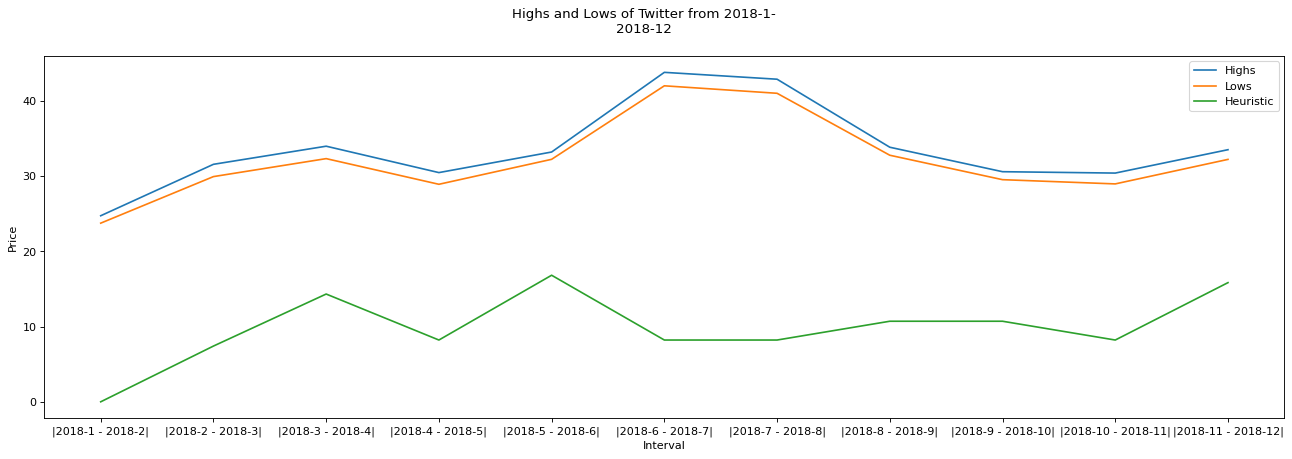

In [23]:
plot_single_company_w_semantic("INFY", "2018-01", "2018-12", 1)
plot_single_company_w_semantic("NKE", "2018-01", "2018-12", 1)
plot_single_company_w_semantic("TSLA", "2018-01", "2018-12", 1)
plot_single_company_w_semantic("AAPL", "2018-01", "2018-12", 1)
plot_single_company_w_semantic("FB", "2018-01", "2018-12", 1)
plot_single_company_w_semantic("NFLX", "2018-01", "2018-12", 1)
plot_single_company_w_semantic("TWTR", "2018-01", "2018-12", 1)